<a href="https://colab.research.google.com/github/PitanoGit/AEDSII-TP1/blob/main/Copy_of_Valgrind_Simulador_de_Cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valgrind e  Simulação de Cache: **Cachegrind**




Este laboratório apresenta o uso da ferramenta cachegrind do ambiente Valgrind, [para maiores informações consulte aqui](https://valgrind.org/docs/manual/cg-manual.html)

**Importante**: 
* A primeira execução do Cachegrind irá fazer a instalação da ferramenta e pode demorar um pouco mais. 
* Os laboratorios usam uma multiplicação de matrizes como exemplo. O tamanho da matriz cresce com  $O(N^2)$ e o tempo de execução com $O(N^3)$.
* Os exemplos estão em C. Mas o Cachegrind trabalha sobre o executável e pode ser usado em qualquer binário. 
* Fique a vontade para contribuir.


## Inicialização

Primeiro, configurar o laboratório.

In [ ]:
!pip install git+git://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter
%load_ext nvcc_plugin

  Cloning git://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-if214n9h
  Running command git clone -q git://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-if214n9h
  Created wheel for ColabPlugin: filename=ColabPlugin-blind-cp36-none-any.whl size=12717 sha256=e31ea54e6dfac8a8322c04d5269b5625a6df8f791def6d759d3899764ce58eec
  Stored in directory: /tmp/pip-ephem-wheel-cache-m4_g29jl/wheels/87/ae/09/21c6e192181a0472e20ddd1d5212e2cbb113f00ebe14330d0d
Successfully built ColabPlugin
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


# Specify all cache parameters

A extensão **\%\%cachegrind** é semelhante a linha de comando, importante que os tamanhos de cache devem ser potência de 2, a linha além de potência de 2 começa com 32 bytes. A ordem dos parametros é tamanho da cache, associatividade e tamanho da linha. Os flags para cache de dados, de instruções e de último nível são **D1**, **I1**, and **LL**, respectivamente.

In [ ]:
%%cachegrind --D1=32768,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {
  
  int n = 100;
  int a[n][n], b[n][n], c[n][n];
  
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;   
      }
  }
  
  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;   
      }
  } 
  return 0;
}


I1  misses:         3,685
LLi misses:         3,514
I1  miss rate:       0.01%
LLi miss rate:       0.01%

D   refs:      13,474,774  (12,993,005 rd   + 481,769 wr)
D1  misses:       180,018  (   149,402 rd   +  30,616 wr)
LLd misses:        53,217  (    22,853 rd   +  30,364 wr)
D1  miss rate:        1.3% (       1.1%     +     6.4%  )
LLd miss rate:        0.4% (       0.2%     +     6.3%  )

LL refs:          183,703  (   153,087 rd   +  30,616 wr)
LL misses:         56,731  (    26,367 rd   +  30,364 wr)
LL miss rate:         0.1% (       0.1%     +     6.3%  )


## Atenção aos resultados 

Valgrind quando simula a cache ele também simula a inicialização do sistema.
Portanto, quando for utilizar o valgrind esteja ciente que se o seu código for muito simples será mascarado pela inicialização do sistema.

In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file

int main(int argc, char const *argv[]) {
  //# empty code
}


I1  misses:        3,635
LLi misses:        3,509
I1  miss rate:      0.09%
LLi miss rate:      0.09%

D   refs:      1,203,059  (771,626 rd   + 431,433 wr)
D1  misses:      284,855  (219,932 rd   +  64,923 wr)
LLd misses:       47,873  ( 21,065 rd   +  26,808 wr)
D1  miss rate:      23.7% (   28.5%     +    15.0%  )
LLd miss rate:       4.0% (    2.7%     +     6.2%  )

LL refs:         288,490  (223,567 rd   +  64,923 wr)
LL misses:        51,382  ( 24,574 rd   +  26,808 wr)
LL miss rate:        1.0% (    0.5%     +     6.2%  )


## Exemplo de código mascarado

Abaixo é apresentado um código de **transposição de matrizes** sendo mascarado pela inicialização do sistema.




In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void trans(int M, int N) { 
    int i, j, tmp;
    for (i = 0; i < N; i++)
        for (j = 0; j < M; j++) {
            tmp = A[i][j];
            B[j][i] = tmp;
        }   
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;

  trans(n, n); //# transposição de matrizes
  return 0;
}


I1  misses:        3,643
LLi misses:        3,517
I1  miss rate:      0.09%
LLi miss rate:      0.09%

D   refs:      1,221,822  (787,247 rd   + 434,575 wr)
D1  misses:      286,142  (220,065 rd   +  66,077 wr)
LLd misses:       48,167  ( 21,102 rd   +  27,065 wr)
D1  miss rate:      23.4% (   28.0%     +    15.2%  )
LLd miss rate:       3.9% (    2.7%     +     6.2%  )

LL refs:         289,785  (223,708 rd   +  66,077 wr)
LL misses:        51,684  ( 24,619 rd   +  27,065 wr)
LL miss rate:        1.0% (    0.5%     +     6.2%  )


## Resultados **somente inicialização X transposição de matrizes**

Somente Inicialização:
* D   refs:      1,203,059  (771,626 rd   + 431,433 wr)
* D1  misses:      284,860  (219,936 rd   +  64,924 wr)

Transposição de matrizes:
* D   refs:      1,221,822  (787,247 rd   + 434,575 wr)
* D1  misses:      286,147  (220,069 rd   +  66,078 wr)

Note que a diferença é pequena, sendo para a cache dados L1:
* D refs: 1221822 - 1203059 = 18763
* D1 misses: 286147 - 284860 = 1287

## Solução: Mais trabalho para o algoritmo

Uma solução é fazer com que o seu código der mais trabalho para cache de dados, assim a inicialização não irá mascarar os resultados.



### Tranposição simples

In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void trans(int M, int N) { 
    int i, j, tmp;
    for (i = 0; i < N; i++)
        for (j = 0; j < M; j++) {
            tmp = A[i][j];
            B[j][i] = tmp;
        }   
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;
      
  for (int i; i < 2000; ++i)
    trans(n, n); //# transposição de matrizes
  return 0;
}


I1  misses:         3,644
LLi misses:         3,519
I1  miss rate:       0.01%
LLi miss rate:       0.01%

D   refs:      24,144,358  (19,541,868 rd   + 4,602,490 wr)
D1  misses:     2,590,994  (   477,941 rd   + 2,113,053 wr)
LLd misses:        48,169  (    21,104 rd   +    27,065 wr)
D1  miss rate:       10.7% (       2.4%     +      45.9%  )
LLd miss rate:        0.2% (       0.1%     +       0.6%  )

LL refs:        2,594,638  (   481,585 rd   + 2,113,053 wr)
LL misses:         51,688  (    24,623 rd   +    27,065 wr)
LL miss rate:         0.1% (       0.0%     +       0.6%  )


In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void transpose_32_32(int M, int N) {
    int BLOCK_SIZE, rowIndex, colIndex, blockedRowIndex, blockedColIndex, eBlockDiagl, iBlockDiagl;
    BLOCK_SIZE = 8;        
    for (colIndex = 0; colIndex < M; colIndex += BLOCK_SIZE) {
        for (rowIndex = 0; rowIndex < N; rowIndex += BLOCK_SIZE) {
            for (blockedRowIndex = rowIndex; blockedRowIndex < rowIndex + BLOCK_SIZE; ++blockedRowIndex) {
                for (blockedColIndex = colIndex; blockedColIndex < colIndex + BLOCK_SIZE; ++blockedColIndex) {
                    if (blockedRowIndex != blockedColIndex)
                        B[blockedColIndex][blockedRowIndex] = A[blockedRowIndex][blockedColIndex];
                    else {
                        eBlockDiagl = A[blockedRowIndex][blockedColIndex];
                        iBlockDiagl = blockedRowIndex;
                    }
                }
                if (colIndex == rowIndex)
                    B[iBlockDiagl][iBlockDiagl] = eBlockDiagl;               
            }
        }
    } 
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;
  for (int i; i < 2000; ++i)
    transpose_32_32(n, n); //# transposição de matrizes 32x32
  return 0;
}


I1  misses:         3,649
LLi misses:         3,524
I1  miss rate:       0.01%
LLi miss rate:       0.01%

D   refs:      29,162,358  (26,245,868 rd   + 2,916,490 wr)
D1  misses:     1,842,994  (   477,941 rd   + 1,365,053 wr)
LLd misses:        48,169  (    21,104 rd   +    27,065 wr)
D1  miss rate:        6.3% (       1.8%     +      46.8%  )
LLd miss rate:        0.2% (       0.1%     +       0.9%  )

LL refs:        1,846,643  (   481,590 rd   + 1,365,053 wr)
LL misses:         51,693  (    24,628 rd   +    27,065 wr)
LL miss rate:         0.1% (       0.0%     +       0.9%  )


### Processando os dados: **Transposição simples X Transposição 32x32**

Note que a cache de dados teve maiores valores na transposição 32x32:

* Transposição simples: 24,144,358
* Transposição 32x32:   29,162,358

Contudo as falhas na transposição 32x32 foram menores:

* Transposição simples: 10.7%
* Transposição 32x32:   6.3%

Logo, quanto menos falha na cache L1 melhor.

# Variando o tamanho da Cache e visualizando falhas e taxa de falhas

A extensão **\%\%rangecachegrind** executa várias vezes com tamanhos de cache especificados pela lista **datacache=(4,8,16,32)**, em Kbytes. O usuário especifica a associatividade (**ways**) e o tamanho do linha  (**line**), os gráficos são gerados de forma automática.

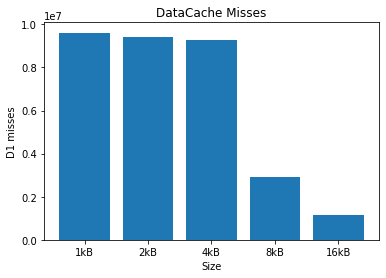

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {
  
  int n = 200;
  int a[n][n], b[n][n], c[n][n];
  
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;   
      }
  }
  
  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;   
      }
  } 
  return 0;
}

# Tarefa

Variando os valores da cache de dados, ways e a lines (Utilize criatividade para mostrar )

**Agoritmo Recursivo(otimizado):**



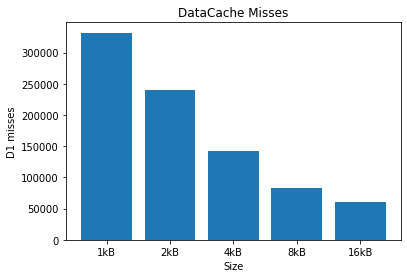

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

void hanoi_recursivo(int n,char origem,char destino,char auxiliar){	
	if(n==1){ 
		//printf("\nMova o disco 1 da base %c para a base %c",origem ,destino);
		return;
	}	
	hanoi_recursivo(n-1,origem,auxiliar,destino);	
	//printf("\nMova o disco %d da base %c para a base %c",n,origem,destino);	
	hanoi_recursivo(n-1,auxiliar,destino,origem);
}

int main(){	
	hanoi_recursivo(15,'A','C','B');
	return 0;
}

**Agoritmo Iterativo:**



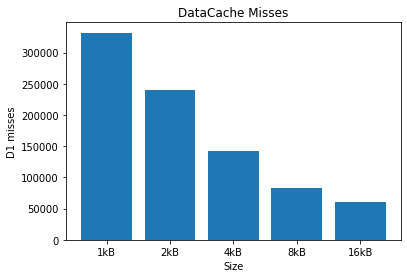

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

void hanoi_iterativo (int n) {
    
    int origem, destino, k ;  
    for(k=1; k < (1 << n); k++) {        
        origem = (k&(k-1))%3 ;        
        destino   = ((k|(k-1))+1)%3 ;        
        //printf("Mova disco de %d para %d\n", origem, destino) ;
    }
}

int main(){	
	hanoi_iterativo(15);	
	return 0;
}

**Agoritmo Iterativo:**
4 ways - 64 lines


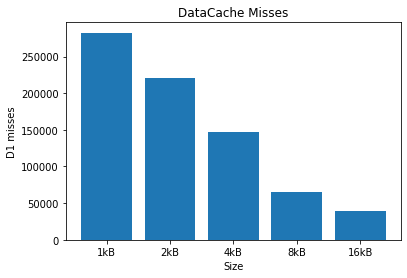

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=4; line=64; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

void hanoi_recursivo(int n,char origem,char destino,char auxiliar){	
	if(n==1){ 
		//printf("\nMova o disco 1 da base %c para a base %c",origem ,destino);
		return;
	}	
	hanoi_recursivo(n-1,origem,auxiliar,destino);	
	//printf("\nMova o disco %d da base %c para a base %c",n,origem,destino);	
	hanoi_recursivo(n-1,auxiliar,destino,origem);
}

int main(){	
	hanoi_recursivo(15,'A','C','B');
	return 0;
}

**Agoritmo Recursivo(otimizado):**
4 ways - 64 lines


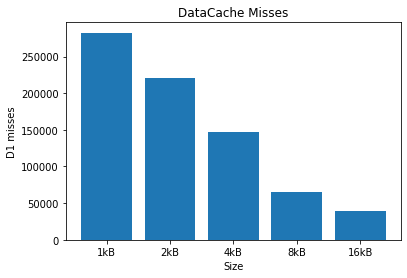

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=4; line=64; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

void hanoi_recursivo(int n,char origem,char destino,char auxiliar){	
	if(n==1){ 
		//printf("\nMova o disco 1 da base %c para a base %c",origem ,destino);
		return;
	}	
	hanoi_recursivo(n-1,origem,auxiliar,destino);	
	//printf("\nMova o disco %d da base %c para a base %c",n,origem,destino);	
	hanoi_recursivo(n-1,auxiliar,destino,origem);
}

int main(){	
	hanoi_recursivo(15,'A','C','B');
	return 0;
}

**Valgrind-Iterativo:**


In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file

#include <stdio.h>
#include <stdlib.h>


void hanoi_iterativo (int n) {
    
    int origem, destino, k ;  
    for(k=1; k < (1 << n); k++) {        
        origem = (k&(k-1))%3 ;        
        destino   = ((k|(k-1))+1)%3 ;        
        //printf("Mova disco de %d para %d\n", origem, destino) ;
    }
}

int main(){	
	hanoi_iterativo(25);	
	return 0;
}



I1  misses:            3,639
LLi misses:            3,513
I1  miss rate:          0.00%
LLi miss rate:          0.00%

D   refs:        437,410,668  (302,761,509 rd   + 134,649,159 wr)
D1  misses:          284,855  (    219,932 rd   +      64,923 wr)
LLd misses:           47,873  (     21,065 rd   +      26,808 wr)
D1  miss rate:           0.1% (        0.1%     +         0.0%  )
LLd miss rate:           0.0% (        0.0%     +         0.0%  )

LL refs:             288,494  (    223,571 rd   +      64,923 wr)
LL misses:            51,386  (     24,578 rd   +      26,808 wr)
LL miss rate:            0.0% (        0.0%     +         0.0%  )


**Valgrind-Recursivo:**


In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file

#include <stdio.h>
#include <stdlib.h>


void hanoi_recursivo(int n,char origem,char destino,char auxiliar){	
	if(n==1){ 
		//printf("\nMova o disco 1 da base %c para a base %c",origem ,destino);
		return;
	}	
	hanoi_recursivo(n-1,origem,auxiliar,destino);	
	//printf("\nMova o disco %d da base %c para a base %c",n,origem,destino);	
	hanoi_recursivo(n-1,auxiliar,destino,origem);
}

int main(){	
	hanoi_recursivo(25,'A','C','B');
	return 0;
}



I1  misses:        3,635
LLi misses:        3,509
I1  miss rate:      0.09%
LLi miss rate:      0.09%

D   refs:      1,203,057  (771,626 rd   + 431,431 wr)
D1  misses:      284,855  (219,932 rd   +  64,923 wr)
LLd misses:       47,873  ( 21,065 rd   +  26,808 wr)
D1  miss rate:      23.7% (   28.5%     +    15.0%  )
LLd miss rate:       4.0% (    2.7%     +     6.2%  )

LL refs:         288,490  (223,567 rd   +  64,923 wr)
LL misses:        51,382  ( 24,574 rd   +  26,808 wr)
LL miss rate:        1.0% (    0.5%     +     6.2%  )


# Explicação dos resultados

Ao dobrar a quantidade de linhas e caminhos disponíveis para a cache é possivel observar uma diminuição da quantidade de D1 misses, ou seja, a efetividade da cache melhora. Tomando o algoritmo melhorado como referência, com a ajuda dos gráficos de D1 misses abaixo corroboram com o resultado obtido também na parte deste trabalho realizada em nosso computador:
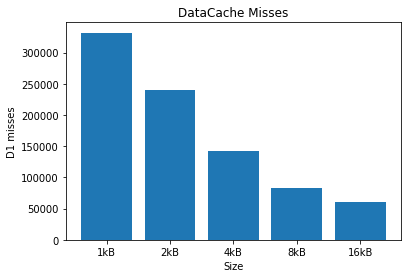
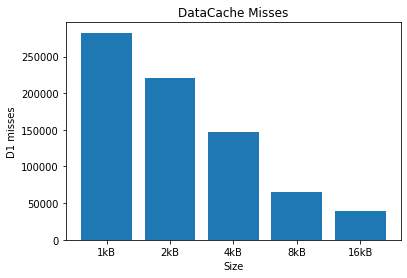



